# **SimCLR in PyTorch** 

Downloading packages and importing necessary libraries

In [1]:
pip install utils

In [2]:
pip install simclr

In [17]:
# Useful imports

import numpy as np
import torch
from torchvision import transforms 
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

import os
from PIL import Image
from collections import OrderedDict, namedtuple

import random
import argparse 

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

In [4]:
import requests
import zipfile
import io

Downloading a subset of the imagenet dataset

In [5]:
!gdown https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g

Downloading...
From: https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g
To: /content/milli_imagenet.zip
92.9MB [00:00, 95.9MB/s]


In [6]:
with zipfile.ZipFile('milli_imagenet.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

Add additional data to the imagenet data using augmentations

In [7]:
class MyDataset(Dataset):
    def __init__(self, args):
        self.args = args
        with open(os.path.join(args.datapath, "train","names.txt")) as f:
            self.filenames = f.read().split('\n')
 
    def __len__(self):
        return len(self.filenames)

    def tensorify(self, img):
        return transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(
            transforms.ToTensor()(img)
            )
    
    def get_color_distortion(self, s=1.0):
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        rnd_color_jitter =  transforms.RandomApply([color_jitter], p=0.8)
        rnd_gray =  transforms.RandomGrayscale(p=0.2)
        color_distort =  transforms.Compose([rnd_color_jitter, rnd_gray])
        return color_distort

    def augmented_image(self, img):
        return self.get_color_distortion(1)(
            transforms.RandomResizedCrop(224)(img)
            ) 

    def __getitem__(self, idx):
        img = transforms.Resize((224, 224))(
                                Image.open(os.path.join(args.datapath, 'train', self.filenames[idx])).convert('RGB')
                            )
        return {
        'image1':self.tensorify(
            self.augmented_image(img)
            ), 
        'image2': self.tensorify(
            self.augmented_image(img)
            )
        }

ReLU

In [8]:
def get_model(args):
    resnet = resnet18(pretrained=False)

    head = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(resnet.fc.in_features, 100)),
        ('added_relu1', nn.ReLU(inplace=True)),
        ('fc2', nn.Linear(100, 100)),
        ('added_relu2', nn.ReLU(inplace=True)),
        ('fc3', nn.Linear(100, 100))
    ]))

    resnet.fc = head

    if args.multiple_gpus:
        resnet = nn.DataParallel(resnet)

    resnet.to(args.device)

    return resnet

Loss function and a method to plot the losses

In [9]:
tau = 0.05

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [10]:
def plot_losses(arr, legend_name):
    plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(arr)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

Defining the simCLR class

In [11]:
class SimCLR:
    def __init__(self, model, optimizer, dataloaders, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.loss_fn = loss_fn
        
    def load_model(self, args):
        self.model.load_state_dict(torch.load(args.model_path), strict=False)

        if 'remove_top_layers' in vars(args):
            if args.remove_top_layers > 0:
                if args.multiple_gpus:
                    temp = list(self.model.module.fc.children())
                    if args.remove_top_layers <= len(temp):
                        self.model.module.fc = torch.nn.Sequential(*temp[:-args.remove_top_layers])
                else:
                    temp = list(self.model.fc.children())
                    if args.remove_top_layers <= len(temp):
                        self.model.fc = torch.nn.Sequential(*temp[:-args.remove_top_layers])

    def get_representations(self, args, mode):

        self.model.eval()

        res = {
        'X':torch.FloatTensor(),
        'Y':torch.LongTensor()
        }

        with torch.no_grad():
            for batch in self.dataloaders[mode]:
                x = batch['image'].to(args.device)
                label = batch['label']

                # get their outputs
                pred = self.model(x)

                res['X'] = torch.cat((res['X'], pred.cpu()))
                res['Y'] = torch.cat((res['Y'], label.cpu()))


        res['X'] = np.array(res['X'])
        res['Y'] = np.array(res['Y'])

        return res

    def train(self, args, num_epochs, log_interval):
        '''
        trains self.model on the train dataset for num_epochs
        and saves model and loss graph after log_interval
        number of epochs
        '''
        
        batch_losses = []

        def logging():
            # Plot the training losses Graph and save it
            
            Path(os.path.join(args.respath,"plots")).mkdir(parents=True, exist_ok=True)
            
            utils.plotfuncs.plot_losses(batch_losses, 'Training Losses', os.path.join(args.respath,'plots/training_losses.png'))
            
            Path(os.path.join(args.respath,"model")).mkdir(parents=True, exist_ok=True)
            
            # Store model and optimizer files
            torch.save(self.model.state_dict(), os.path.join(args.respath,"model/model.pth"))
            torch.save(self.optimizer.state_dict(), os.path.join(args.respath,"model/optimizer.pth"))
            np.savez(os.path.join(args.respath,"model/lossesfile"), np.array(batch_losses))
        
        self.model.train()
    
        # run a for loop for num_epochs
        for epoch in range(num_epochs):

            # run a for loop for each batch
            for batch in self.dataloaders['train']:

                # zero out grads
                self.optimizer.zero_grad()

                x1 = batch['image1'].to(args.device)
                x2 = batch['image2'].to(args.device)

                # get their outputs
                y1 = self.model(x1)
                y2 = self.model(x2)

                # get loss value
                loss = self.loss_fn(y1, y2)
                
                batch_losses.append(loss.cpu().data.item())

                # perform backprop on loss value to get gradient values
                loss.backward()

                # run the optimizer
                self.optimizer.step()
                
            if epoch%log_interval == log_interval-1:
                logging()
            
        logging()

In [12]:
class SimCLR:
    def __init__(self, model, optimizer, dataloaders, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.loss_fn = loss_fn

    def train(self, args, num_epochs, log_interval):
        batch_losses = []

        self.model.train()
    
        # run a for loop for num_epochs
        for epoch in range(num_epochs):

            # run a for loop for each batch
            for step, batch in enumerate(self.dataloaders['train']):
                # zero out grads
                self.optimizer.zero_grad()

                x1 = batch['image1'].to(args.device)
                x2 = batch['image2'].to(args.device)

                # get their outputs
                y1 = self.model(x1)
                y2 = self.model(x2)

                # get loss value
                loss = self.loss_fn(y1, y2)

                batch_losses.append(loss.cpu().data.item())

                # perform backprop on loss value to get gradient values
                loss.backward()

                # run the optimizer
                self.optimizer.step()
                
                if step % log_interval == 0:
                    print(f'Epoch: {epoch} / {num_epochs} Step: {step} Loss: {loss.item()}')
                
                if step >= 5:
                  break
            
        plot_losses(batch_losses, 'Training Losses')

1250 images found for training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 / 5 Step: 0 Loss: 3.4899699687957764
Epoch: 0 / 5 Step: 5 Loss: 2.3988053798675537
Epoch: 1 / 5 Step: 0 Loss: 2.9264016151428223
Epoch: 1 / 5 Step: 5 Loss: 2.5806615352630615
Epoch: 2 / 5 Step: 0 Loss: 2.5703492164611816
Epoch: 2 / 5 Step: 5 Loss: 2.6052589416503906
Epoch: 3 / 5 Step: 0 Loss: 2.6131539344787598
Epoch: 3 / 5 Step: 5 Loss: 2.610886812210083
Epoch: 4 / 5 Step: 0 Loss: 2.6496028900146484
Epoch: 4 / 5 Step: 5 Loss: 2.798966884613037


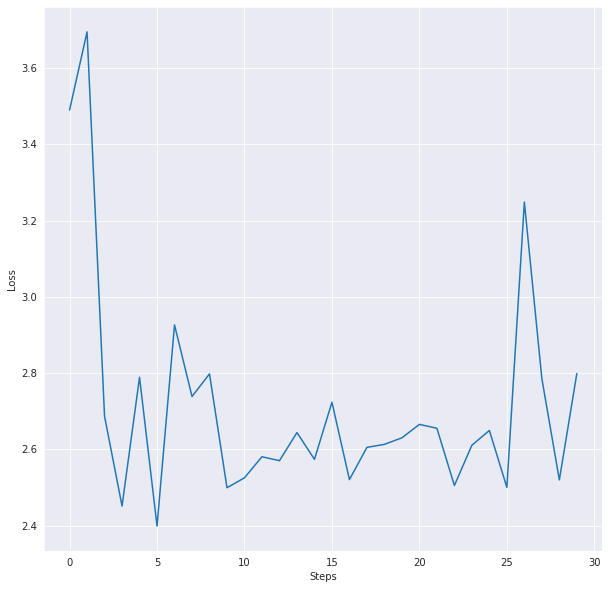

In [18]:
args = {
    'datapath': '/content/milli_imagenet',
    'cuda': False,
    'batch_size': 8,
    'num_workers': 2,
    'multiple_gpus': False,
}
args['device'] = torch.device('cuda' if args['cuda'] else 'cpu')
args = namedtuple('Args', args.keys())(*args.values())

model = get_model(args)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
    )

dataloaders = {}
ds = MyDataset(args)
print(f'{len(ds)} images found for training')

dataloaders['train'] = torch.utils.data.DataLoader(
    ds, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=args.num_workers
    )

loss_fn = loss_function
simclrobj = SimCLR(model, optimizer, dataloaders, loss_fn)
simclrobj.train(args, 5, 5)